# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

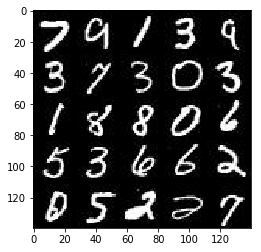

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

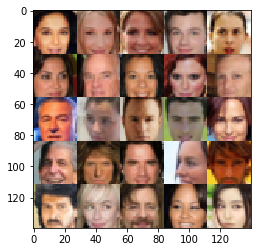

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,
        (None, image_width, image_height, image_channels),
        name='input_real')
    input_z = tf.placeholder(tf.float32,
        (None, z_dim),
        name='input_z')
    learn_rate = tf.placeholder(tf.float32,
        name='learn_rate')

    return (input_real, input_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Zero-centered Normal distribution weights initializer
def w_init(stddev=0.02):
    return tf.random_normal_initializer(stddev=stddev)

In [7]:
import numpy as np

def discriminator(images, reuse=False, alpha=0.2, prnt=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    conv_depth = [32, 64, 128, 256] # [64, 128, 256]
    conv_ksize = [3, 5, 5, 5]
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
       
        # CONV 1
        conv_1 = tf.layers.conv2d(
            images, conv_depth[0], conv_ksize[0], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=True) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV 2
        conv_2 =  tf.layers.conv2d(
            conv_1, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=True) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV 3
        conv_3 =  tf.layers.conv2d(
            conv_2, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_3 = tf.layers.batch_normalization(conv_3, training=True) # Batchnorm
        conv_3 = tf.maximum(alpha * conv_3, conv_3) # Leaky_ReLU
        if prnt: print('CONV 3: {}'.format(conv_3.get_shape().as_list()))
        
        # CONV 4
        conv_4 =  tf.layers.conv2d(
            conv_3, conv_depth[3], conv_ksize[3], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_4 = tf.layers.batch_normalization(conv_4, training=True) # Batchnorm
        conv_4 = tf.maximum(alpha * conv_4, conv_4) # Leaky_ReLU
        if prnt: print('CONV 4: {}'.format(conv_4.get_shape().as_list()))
        
        # Logits and Output
        logits = tf.reshape(conv_4, (-1, np.prod(conv_4.get_shape().as_list()[1:]))) # Flatten
        logits = tf.layers.dense(logits, 1,
            kernel_initializer=w_init()) # Fully connected layer
        output = tf.sigmoid(logits) # Sigmoid activation for classification
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))
        
    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, img_size=28, prnt=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    conv_depth = [128, 64, 32, out_channel_dim]
    conv_ksize = [5, 5, 5, 3]
    
    with tf.variable_scope('generator', reuse=not is_train):
        '''
        tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
        # Fully connected layer
        dim = [4, 256]
        layer_0 = tf.layers.dense(z, dim[0]**2*dim[1], kernel_initializer=w_init())
        layer_0 = tf.reshape(layer_0, (-1, dim[0], dim[0], dim[1])) # First 'feature' stack
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train) # Batchnorm
        layer_0 =  tf.maximum(alpha * layer_0, layer_0) # Leaky_ReLU
        if prnt: print('FC Layer 0: {}'.format(layer_0.get_shape().as_list()))
        
        # CONV_T 0
        conv_0 = tf.layers.conv2d_transpose(
            layer_0, conv_depth[0], conv_ksize[0], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_0 = tf.layers.batch_normalization(conv_0, training=is_train) # Batchnorm
        conv_0 = tf.maximum(alpha * conv_0, conv_0) # Leaky_ReLU
        if prnt: print('CONV_T 0: {}'.format(conv_0.get_shape().as_list()))
        
        # CONV_T 1
        conv_1 = tf.layers.conv2d_transpose(
            conv_0, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV_T 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV_T 2
        conv_2 = tf.layers.conv2d_transpose(
            conv_1, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV_T 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV_T 3
        conv_3 = tf.layers.conv2d_transpose(
            conv_2, conv_depth[3], conv_ksize[3], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        if prnt: print('CONV_T 3: {}'.format(conv_3.get_shape().as_list()))
        
        # Crop
        crop = tf.slice(conv_3, [0,2,2,0], [-1,28,28,-1])
        if prnt: print('Crop : {}'.format(crop.get_shape().as_list()))
                
        # Output
        output = tf.tanh(crop) # 
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))    
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_generator(generator, tf)

FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Modified version of 'model_loss()' in DCGAN lesson
    g_model = generator(input_z, out_channel_dim) # Generator output
    d_model_real, d_logits_real = discriminator(input_real) # Discriminator output with real images
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) # Discriminator output with generator images

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: Yes | Labels: Yes
            logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: No
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss      = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: Yes
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake # Combine loss for real and fake inputs
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Modified version of 'model_opt()' in DCGAN lesson
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize and update tf.layers.batch_normalization layers population statistics
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`
- `show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, n_files):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    # Create TF Placeholders for the Neural Network
    input_real, input_z, learn_rate = model_inputs(
        image_width=data_shape[1],
        image_height=data_shape[2],
        image_channels=data_shape[3],
        z_dim=z_dim)
    
    # Build the GANs for training and calculate the loss
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3])
    
    # Create the optimization operations for the GANs
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # Model saver  
    saver = tf.train.Saver()
    
    print_every = 1000 // batch_size
    show_every = 10000 // batch_size
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_num, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(
                    d_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_num, n_files // batch_size),
                          "D Loss: {:.4f}...".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 7... Epoch 1/2... Batch 6/468... D Loss: 0.1163... G Loss: 2.6289
Step 14... Epoch 1/2... Batch 13/468... D Loss: 6.5536... G Loss: 0.0020
Step 21... Epoch 1/2... Batch 20/468... D Loss: 0.7328... G Loss: 9.6536
Step 28... Epoch 1/2... Batch 27/468... D Loss: 3.0031... G Loss: 0.1641
Step 35... Epoch 1/2... Batch 34/468... D Loss: 0.4647... G Loss: 4.5230
Step 42... Epoch 1/2... Batch 41/468... D Loss: 1.3939... G Loss: 3.4773
Step 49... Epoch 1/2... Batch 48/468... D Loss: 1.0673... G Loss: 0.5782
Step 56... Epoch 1/2... Batch 55/468... D Loss: 0.8563... G Loss: 2.9017
Step 63... Epoch 1/2... Batch 62/468... D Loss: 0.5324... G Loss: 1.9217
Step 70... Epoch 1/2... Batch 69/468... D Loss: 1.3641... G Loss: 0.4022
Step 77... Epoch 1/2... Batch 76/468... D Loss: 1.1469... G Loss: 4.0197


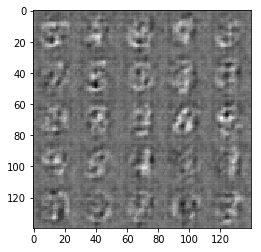

Step 84... Epoch 1/2... Batch 83/468... D Loss: 1.9218... G Loss: 0.1938
Step 91... Epoch 1/2... Batch 90/468... D Loss: 1.7189... G Loss: 5.9128
Step 98... Epoch 1/2... Batch 97/468... D Loss: 0.8925... G Loss: 0.6722
Step 105... Epoch 1/2... Batch 104/468... D Loss: 0.2237... G Loss: 2.6078
Step 112... Epoch 1/2... Batch 111/468... D Loss: 0.1194... G Loss: 2.8809
Step 119... Epoch 1/2... Batch 118/468... D Loss: 0.0775... G Loss: 3.4607
Step 126... Epoch 1/2... Batch 125/468... D Loss: 0.0693... G Loss: 3.2616
Step 133... Epoch 1/2... Batch 132/468... D Loss: 0.0547... G Loss: 6.1640
Step 140... Epoch 1/2... Batch 139/468... D Loss: 0.0309... G Loss: 4.0783
Step 147... Epoch 1/2... Batch 146/468... D Loss: 0.0240... G Loss: 5.0427
Step 154... Epoch 1/2... Batch 153/468... D Loss: 0.9683... G Loss: 4.7920


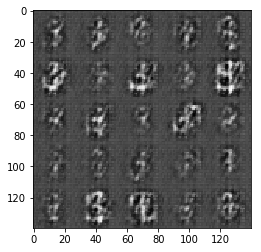

Step 161... Epoch 1/2... Batch 160/468... D Loss: 0.2305... G Loss: 2.1681
Step 168... Epoch 1/2... Batch 167/468... D Loss: 0.5905... G Loss: 1.7059
Step 175... Epoch 1/2... Batch 174/468... D Loss: 0.2938... G Loss: 1.9065
Step 182... Epoch 1/2... Batch 181/468... D Loss: 0.3634... G Loss: 1.4408
Step 189... Epoch 1/2... Batch 188/468... D Loss: 1.2364... G Loss: 2.8652
Step 196... Epoch 1/2... Batch 195/468... D Loss: 0.3744... G Loss: 1.6863
Step 203... Epoch 1/2... Batch 202/468... D Loss: 1.4571... G Loss: 0.3173
Step 210... Epoch 1/2... Batch 209/468... D Loss: 0.2852... G Loss: 2.4848
Step 217... Epoch 1/2... Batch 216/468... D Loss: 0.3824... G Loss: 1.3773
Step 224... Epoch 1/2... Batch 223/468... D Loss: 0.0624... G Loss: 3.9671
Step 231... Epoch 1/2... Batch 230/468... D Loss: 0.0953... G Loss: 2.6540


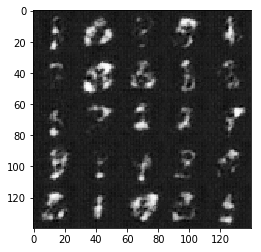

Step 238... Epoch 1/2... Batch 237/468... D Loss: 0.0591... G Loss: 4.1343
Step 245... Epoch 1/2... Batch 244/468... D Loss: 1.7348... G Loss: 5.0130
Step 252... Epoch 1/2... Batch 251/468... D Loss: 1.1313... G Loss: 2.3998
Step 259... Epoch 1/2... Batch 258/468... D Loss: 0.7237... G Loss: 1.0508
Step 266... Epoch 1/2... Batch 265/468... D Loss: 1.1582... G Loss: 1.9595
Step 273... Epoch 1/2... Batch 272/468... D Loss: 0.4464... G Loss: 1.4361
Step 280... Epoch 1/2... Batch 279/468... D Loss: 0.2980... G Loss: 1.7306
Step 287... Epoch 1/2... Batch 286/468... D Loss: 0.2814... G Loss: 1.7765
Step 294... Epoch 1/2... Batch 293/468... D Loss: 0.1910... G Loss: 2.1136
Step 301... Epoch 1/2... Batch 300/468... D Loss: 0.1355... G Loss: 2.8771
Step 308... Epoch 1/2... Batch 307/468... D Loss: 0.2189... G Loss: 1.9361


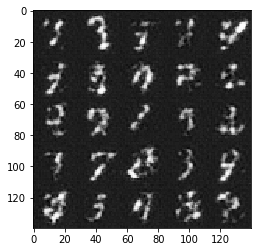

Step 315... Epoch 1/2... Batch 314/468... D Loss: 0.3933... G Loss: 1.3198
Step 322... Epoch 1/2... Batch 321/468... D Loss: 11.3909... G Loss: 0.0001
Step 329... Epoch 1/2... Batch 328/468... D Loss: 1.0342... G Loss: 0.8776
Step 336... Epoch 1/2... Batch 335/468... D Loss: 0.9117... G Loss: 0.9269
Step 343... Epoch 1/2... Batch 342/468... D Loss: 0.9396... G Loss: 2.1845
Step 350... Epoch 1/2... Batch 349/468... D Loss: 0.9495... G Loss: 0.6110
Step 357... Epoch 1/2... Batch 356/468... D Loss: 0.5629... G Loss: 1.1792
Step 364... Epoch 1/2... Batch 363/468... D Loss: 0.8022... G Loss: 3.0954
Step 371... Epoch 1/2... Batch 370/468... D Loss: 0.4845... G Loss: 1.5416
Step 378... Epoch 1/2... Batch 377/468... D Loss: 0.3999... G Loss: 2.1468
Step 385... Epoch 1/2... Batch 384/468... D Loss: 0.3483... G Loss: 1.5952


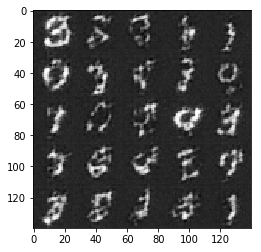

Step 392... Epoch 1/2... Batch 391/468... D Loss: 0.3275... G Loss: 1.6245
Step 399... Epoch 1/2... Batch 398/468... D Loss: 0.2553... G Loss: 1.8814
Step 406... Epoch 1/2... Batch 405/468... D Loss: 0.2040... G Loss: 2.2240
Step 413... Epoch 1/2... Batch 412/468... D Loss: 0.2730... G Loss: 1.7125
Step 420... Epoch 1/2... Batch 419/468... D Loss: 0.1257... G Loss: 2.6172
Step 427... Epoch 1/2... Batch 426/468... D Loss: 0.2914... G Loss: 1.6222
Step 434... Epoch 1/2... Batch 433/468... D Loss: 0.9395... G Loss: 2.0971
Step 441... Epoch 1/2... Batch 440/468... D Loss: 0.4064... G Loss: 2.1734
Step 448... Epoch 1/2... Batch 447/468... D Loss: 0.3572... G Loss: 1.5319
Step 455... Epoch 1/2... Batch 454/468... D Loss: 0.3722... G Loss: 1.4672
Step 462... Epoch 1/2... Batch 461/468... D Loss: 0.2818... G Loss: 3.7013


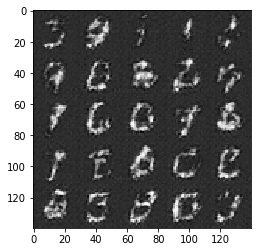

Step 469... Epoch 2/2... Batch 0/468... D Loss: 0.1317... G Loss: 2.4644
Step 476... Epoch 2/2... Batch 7/468... D Loss: 0.0608... G Loss: 3.4206
Step 483... Epoch 2/2... Batch 14/468... D Loss: 0.0759... G Loss: 3.2520
Step 490... Epoch 2/2... Batch 21/468... D Loss: 1.4480... G Loss: 7.1705
Step 497... Epoch 2/2... Batch 28/468... D Loss: 0.9533... G Loss: 0.8289
Step 504... Epoch 2/2... Batch 35/468... D Loss: 0.9199... G Loss: 2.3885
Step 511... Epoch 2/2... Batch 42/468... D Loss: 1.3326... G Loss: 0.3993
Step 518... Epoch 2/2... Batch 49/468... D Loss: 1.1925... G Loss: 3.8506
Step 525... Epoch 2/2... Batch 56/468... D Loss: 2.2016... G Loss: 0.1534
Step 532... Epoch 2/2... Batch 63/468... D Loss: 0.7922... G Loss: 1.7516
Step 539... Epoch 2/2... Batch 70/468... D Loss: 0.4791... G Loss: 1.2615
Step 546... Epoch 2/2... Batch 77/468... D Loss: 0.1831... G Loss: 2.9503


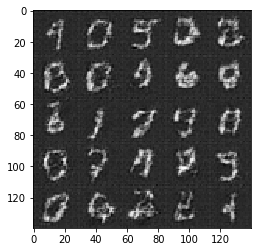

Step 553... Epoch 2/2... Batch 84/468... D Loss: 0.1177... G Loss: 3.0380
Step 560... Epoch 2/2... Batch 91/468... D Loss: 0.1123... G Loss: 3.0462
Step 567... Epoch 2/2... Batch 98/468... D Loss: 0.0425... G Loss: 4.3715
Step 574... Epoch 2/2... Batch 105/468... D Loss: 0.2793... G Loss: 3.8583
Step 581... Epoch 2/2... Batch 112/468... D Loss: 0.6439... G Loss: 0.9165
Step 588... Epoch 2/2... Batch 119/468... D Loss: 0.2978... G Loss: 1.9571
Step 595... Epoch 2/2... Batch 126/468... D Loss: 0.1730... G Loss: 2.4428
Step 602... Epoch 2/2... Batch 133/468... D Loss: 0.2681... G Loss: 1.6804
Step 609... Epoch 2/2... Batch 140/468... D Loss: 0.0435... G Loss: 4.1636
Step 616... Epoch 2/2... Batch 147/468... D Loss: 0.0422... G Loss: 4.5440
Step 623... Epoch 2/2... Batch 154/468... D Loss: 1.8228... G Loss: 0.2134


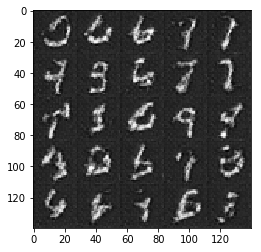

Step 630... Epoch 2/2... Batch 161/468... D Loss: 0.6400... G Loss: 1.6979
Step 637... Epoch 2/2... Batch 168/468... D Loss: 0.7843... G Loss: 0.7762
Step 644... Epoch 2/2... Batch 175/468... D Loss: 0.3116... G Loss: 1.9649
Step 651... Epoch 2/2... Batch 182/468... D Loss: 0.3143... G Loss: 2.2185
Step 658... Epoch 2/2... Batch 189/468... D Loss: 0.2894... G Loss: 1.7617
Step 665... Epoch 2/2... Batch 196/468... D Loss: 0.0583... G Loss: 3.7142
Step 672... Epoch 2/2... Batch 203/468... D Loss: 2.9956... G Loss: 0.0824
Step 679... Epoch 2/2... Batch 210/468... D Loss: 1.1126... G Loss: 0.5323
Step 686... Epoch 2/2... Batch 217/468... D Loss: 0.8405... G Loss: 1.5473
Step 693... Epoch 2/2... Batch 224/468... D Loss: 1.2022... G Loss: 0.4794
Step 700... Epoch 2/2... Batch 231/468... D Loss: 0.8747... G Loss: 1.0097


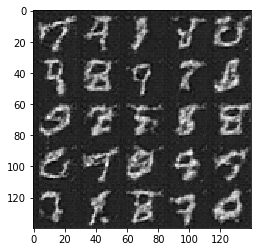

Step 707... Epoch 2/2... Batch 238/468... D Loss: 0.8306... G Loss: 0.8545
Step 714... Epoch 2/2... Batch 245/468... D Loss: 1.4346... G Loss: 0.3261
Step 721... Epoch 2/2... Batch 252/468... D Loss: 0.5050... G Loss: 2.2201
Step 728... Epoch 2/2... Batch 259/468... D Loss: 1.4108... G Loss: 0.3535
Step 735... Epoch 2/2... Batch 266/468... D Loss: 0.4486... G Loss: 1.4956
Step 742... Epoch 2/2... Batch 273/468... D Loss: 0.3604... G Loss: 1.4361
Step 749... Epoch 2/2... Batch 280/468... D Loss: 1.7307... G Loss: 0.2434
Step 756... Epoch 2/2... Batch 287/468... D Loss: 0.5757... G Loss: 1.1425
Step 763... Epoch 2/2... Batch 294/468... D Loss: 0.2432... G Loss: 1.8641
Step 770... Epoch 2/2... Batch 301/468... D Loss: 0.2718... G Loss: 1.7389
Step 777... Epoch 2/2... Batch 308/468... D Loss: 0.3005... G Loss: 1.5659


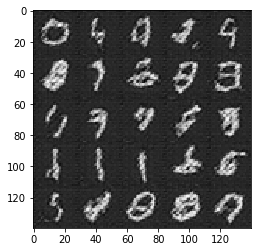

Step 784... Epoch 2/2... Batch 315/468... D Loss: 0.0868... G Loss: 3.1341
Step 791... Epoch 2/2... Batch 322/468... D Loss: 0.0647... G Loss: 3.5540
Step 798... Epoch 2/2... Batch 329/468... D Loss: 0.1743... G Loss: 3.9732
Step 805... Epoch 2/2... Batch 336/468... D Loss: 0.1358... G Loss: 4.5739
Step 812... Epoch 2/2... Batch 343/468... D Loss: 0.0514... G Loss: 3.9040
Step 819... Epoch 2/2... Batch 350/468... D Loss: 0.3761... G Loss: 1.3135
Step 826... Epoch 2/2... Batch 357/468... D Loss: 0.9994... G Loss: 1.6124
Step 833... Epoch 2/2... Batch 364/468... D Loss: 0.6690... G Loss: 1.5872
Step 840... Epoch 2/2... Batch 371/468... D Loss: 0.5988... G Loss: 1.1814
Step 847... Epoch 2/2... Batch 378/468... D Loss: 0.8770... G Loss: 2.7476
Step 854... Epoch 2/2... Batch 385/468... D Loss: 0.3948... G Loss: 1.5759


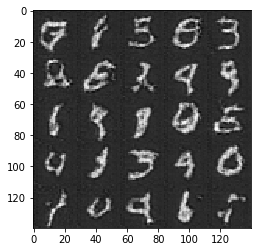

Step 861... Epoch 2/2... Batch 392/468... D Loss: 0.3513... G Loss: 2.9575
Step 868... Epoch 2/2... Batch 399/468... D Loss: 1.3886... G Loss: 0.4009
Step 875... Epoch 2/2... Batch 406/468... D Loss: 0.6555... G Loss: 1.2724
Step 882... Epoch 2/2... Batch 413/468... D Loss: 0.3676... G Loss: 1.4950
Step 889... Epoch 2/2... Batch 420/468... D Loss: 0.1749... G Loss: 2.4418
Step 896... Epoch 2/2... Batch 427/468... D Loss: 0.6270... G Loss: 0.9604
Step 903... Epoch 2/2... Batch 434/468... D Loss: 0.0422... G Loss: 4.7366
Step 910... Epoch 2/2... Batch 441/468... D Loss: 0.0154... G Loss: 5.7757
Step 917... Epoch 2/2... Batch 448/468... D Loss: 0.2040... G Loss: 1.9675
Step 924... Epoch 2/2... Batch 455/468... D Loss: 0.2067... G Loss: 7.1903
Step 931... Epoch 2/2... Batch 462/468... D Loss: 3.3838... G Loss: 3.9191


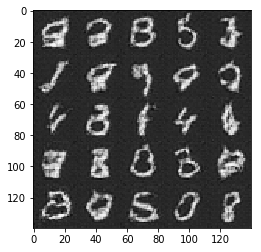

In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
files = glob(os.path.join(data_dir, 'mnist/*.jpg'))
#files = files[:5001]
mnist_dataset = helper.Dataset('mnist', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, len(files))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
celeba_dataset = helper.Dataset('celeba', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, len(files))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.